In [9]:
import gzip
import pickle

import sys, os
from os import path

import time
import numpy as onp

import jax
from jax.lax import scan, cond
from jax import random, flatten_util
import jax.numpy as np
from jax import vjp, custom_vjp, jacfwd, jacrev, vmap
from functools import partial
import openTSNE
from sklearn.utils import check_random_state
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tsne_jax import *

In [10]:
def KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener):
    """
    (R^nxp x R^nxp)--> R
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    Q = y2q(Y)
    return np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10)))

In [11]:
def Hessian_y_y(f, X, Y):
    '''
    nxp, nx2 --> 2n x 2n
    '''
    X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
    Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y)   # row-wise
    H = jax.hessian(f, argnums=1)(X_flat, Y_flat, X_unflattener, Y_unflattener)
    return H

def Mixed_Jacobian_x_y(f, X, Y):
    '''
    Symmetry of mixed partials (order of derivatives doesn't matter)
    nxp, nx2 --> 2n x np
    '''    
    X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
    Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y)   # row-wise
    #J_X_Y = jacrev(jacfwd(f, argnums=0), argnums=1)(X_flat, Y_flat, X_unflattener, Y_unflattener)
    J_X_Y = jacfwd(jacfwd(f, argnums=1), argnums=0)(X_flat, Y_flat, X_unflattener, Y_unflattener)
    return J_X_Y

def d_y_star_d_x(H, J):
    lu, piv= jax.scipy.linalg.lu_factor(H)
    return jax.scipy.linalg.lu_solve((lu, piv), -J), H, J

def d_y_star_d_x_outer(f, X, Y_star):
    return d_y_star_d_x(Hessian_y_y(KL_divergence, X, Y_star), Mixed_Jacobian_x_y(KL_divergence, X, Y_star))
    

In [12]:
def fixed_point(x, y_guess):
    affinity = openTSNE.affinity.PerplexityBasedNN(
        x,
        perplexity=30.0,
        method="annoy",
        random_state=42,
        verbose=True,
    )

    init = openTSNE.initialization.random(
        x, n_components=2, random_state=42, verbose=True,
    )
    
    y_star = openTSNE.TSNEEmbedding(
        init,
        affinity,
        learning_rate=200,
        negative_gradient_method="fft",
        random_state=42,
    )
    y_star.optimize(250, exaggeration=12, momentum=0.8, inplace=True)
    y_star.optimize(750, momentum=0.5, inplace=True)
    return y_star

In [46]:
X, labels = load_data(50)
X = X[onp.argsort(labels)]
key = random.PRNGKey(42)
y_guess = random.normal(key, shape=(X.shape[0], 2))
Y_star = fixed_point(X, y_guess)

===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds


In [47]:
dy, H, J = d_y_star_d_x_outer(KL_divergence, X, Y_star)

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


[-1.6798172e+00 -1.6558219e+00 -1.6168185e+00 -1.5747683e+00
 -1.5121235e+00 -1.4854051e+00 -1.4571021e+00 -1.4342819e+00
 -1.4142861e+00 -1.3986716e+00 -1.3818647e+00 -1.3410940e+00
 -1.3181888e+00 -1.3000563e+00 -1.2797470e+00 -1.2459482e+00
 -1.2259395e+00 -1.2163557e+00 -1.1961128e+00 -1.1931847e+00
 -1.1848339e+00 -1.1804543e+00 -1.1374748e+00 -1.1227977e+00
 -1.1081153e+00 -1.1001620e+00 -1.0951374e+00 -1.0692836e+00
 -1.0651541e+00 -1.0490236e+00 -1.0207410e+00 -1.0200272e+00
 -1.0090090e+00 -9.8744553e-01 -9.7241545e-01 -9.6122128e-01
 -9.5045608e-01 -9.1663694e-01 -8.9124376e-01 -8.7582505e-01
 -8.7431973e-01 -8.6544609e-01 -8.4851092e-01 -8.2447976e-01
 -8.0324781e-01 -7.9645568e-01 -7.8207982e-01 -7.7150095e-01
 -7.4852198e-01 -7.4358231e-01 -7.3354268e-01 -7.2543675e-01
 -7.1400082e-01 -7.0361310e-01 -6.8605024e-01 -6.8139499e-01
 -6.7115426e-01 -6.5450537e-01 -6.2710780e-01 -6.1264306e-01
 -6.0368621e-01 -5.7901901e-01 -5.6550711e-01 -5.5475676e-01
 -5.3820920e-01 -5.28753

Text(0.5, 1.0, 'Eigenvectors Hessian sorted from high to low eigenvalue')

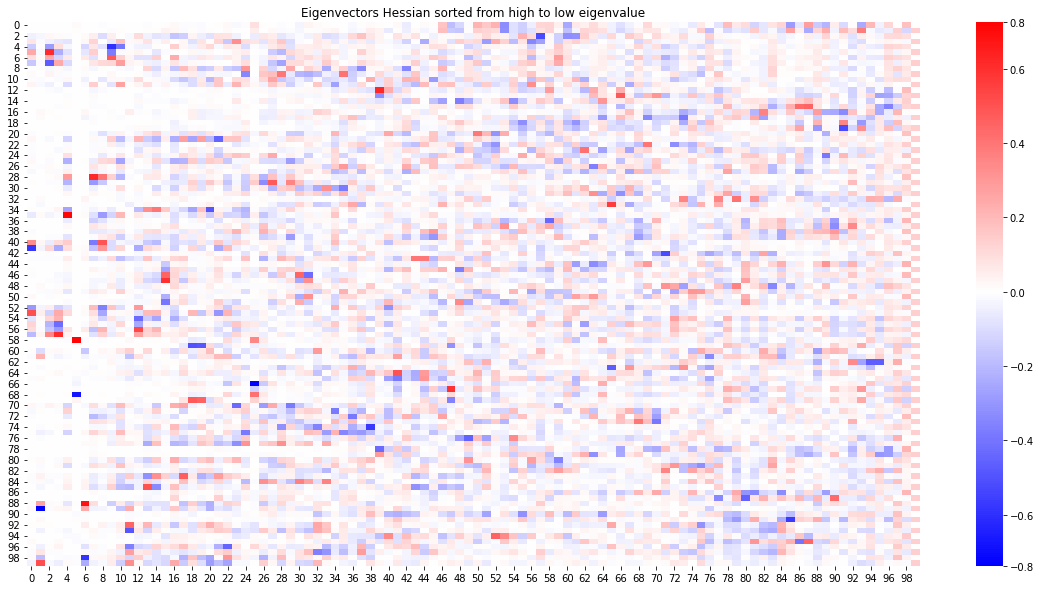

In [49]:
v, w = np.linalg.eigh(-H)
print(v)
w_sorted = np.transpose(np.transpose(w)[np.argsort(v)])
ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(w_sorted, cmap='bwr', norm=(MidpointNormalize(midpoint=0, vmin=onp.min(w_sorted), vmax=onp.max(w_sorted))))
ax.set_title('Eigenvectors Hessian sorted from high to low eigenvalue')

# Blobs

In [5]:
X, y = make_blobs(n_samples=4, n_features=50, centers=4, random_state=0, shuffle=False)
key = random.PRNGKey(42)
y_guess = random.normal(key, shape=(X.shape[0], 2))
Y_star = fixed_point(X, y_guess)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Perplexity value 30 is too high. Using perplexity 1.00 instead


===> Finding 3 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds


In [13]:
dy, H, J = d_y_star_d_x_outer(KL_divergence, X, Y_star)

Computing pairwise distances...
Starting binary search
Entered binary search function


TypeError: can only concatenate tuple (not "float") to tuple

In [ ]:
v, w = np.linalg.eigh(-H)
w_sorted = np.transpose(np.transpose(w)[np.argsort(v)])

In [ ]:
ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(w_sorted, cmap='bwr', norm=(MidpointNormalize(midpoint=0, vmin=onp.min(w_sorted), vmax=onp.max(w_sorted))))
ax.set_title('Eigenvectors Hessian sorted from high to low eigenvalue')

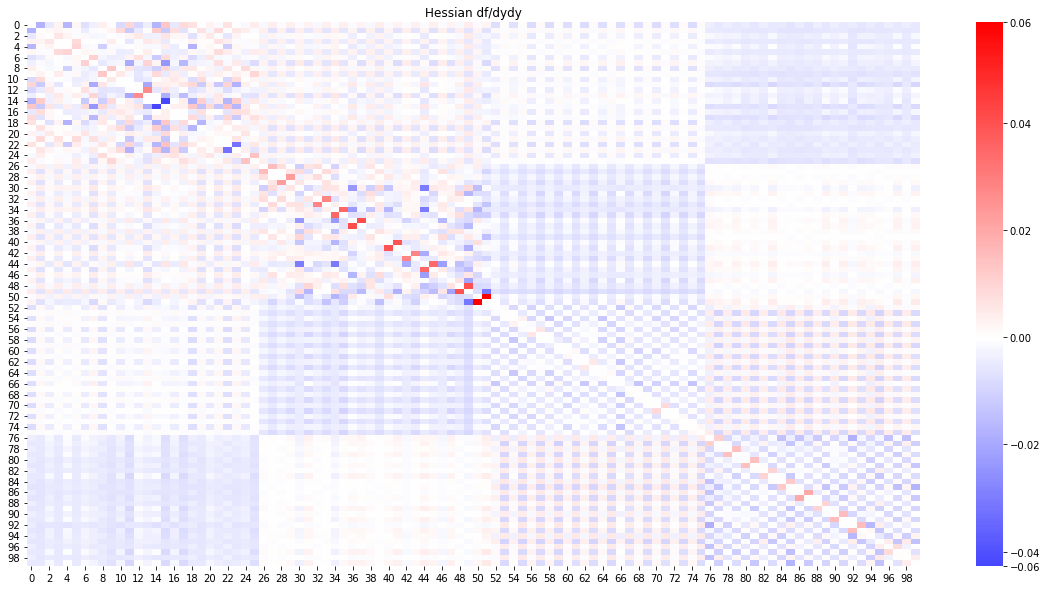

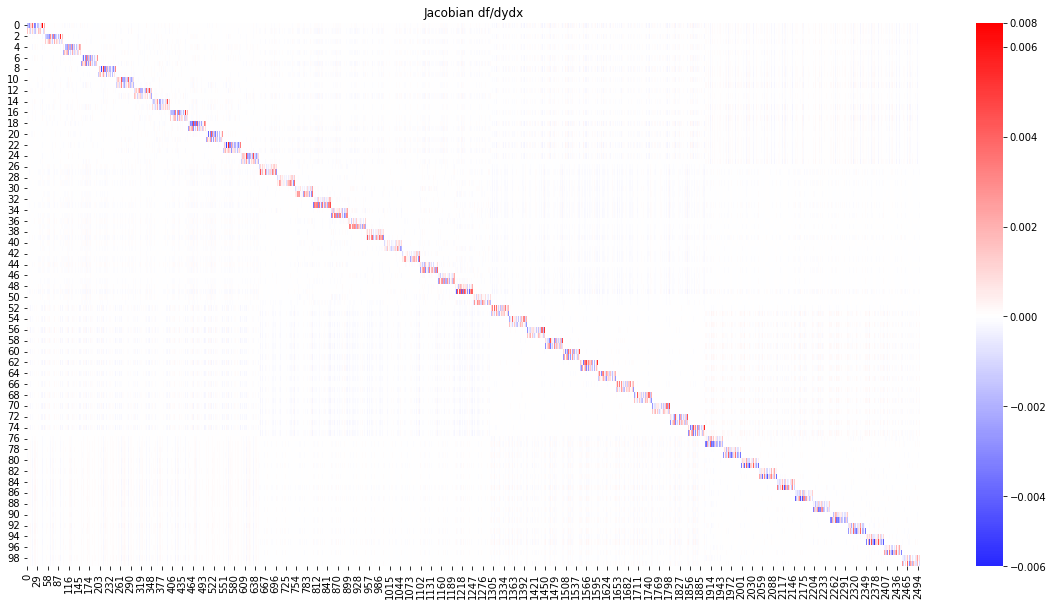

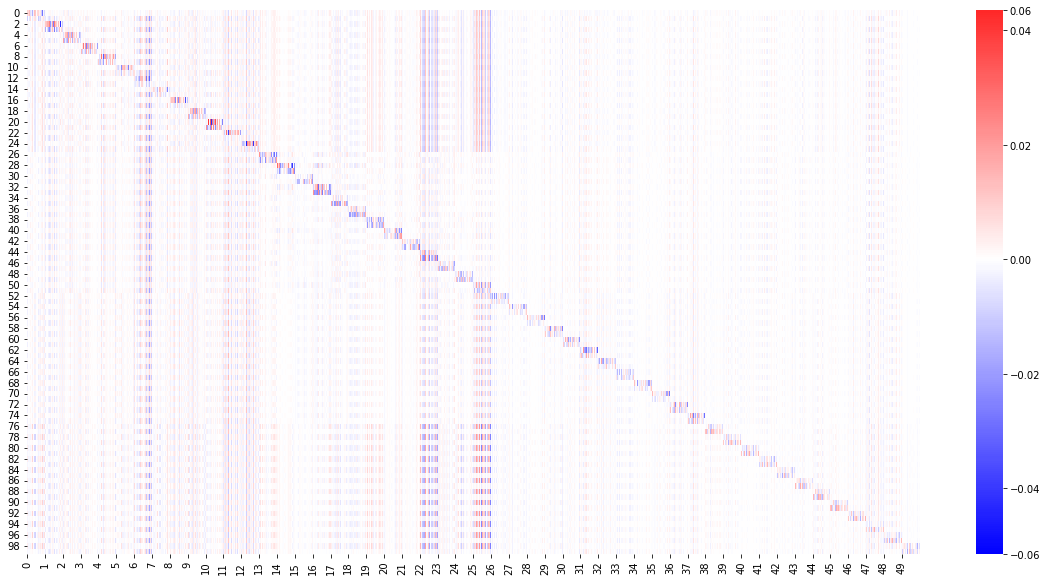

In [22]:
ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(H-np.diag(np.diag(H)), cmap='bwr', norm=(MidpointNormalize(midpoint=0, vmin=onp.min(H-np.diag(np.diag(H))), vmax=onp.max(H-np.diag(np.diag(H))))))
ax.set_title('Hessian df/dydy')

ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(J, cmap='bwr', norm=(MidpointNormalize(midpoint=0, vmin=onp.min(J), vmax=onp.max(J))))
ax.set_title('Jacobian df/dydx')

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(dy, cmap='bwr', norm=(MidpointNormalize(midpoint=0, vmin=onp.min(dy), vmax=onp.max(dy))))
ax.set_xticks(np.arange(0, X.shape[0]*X.shape[1], X.shape[1]), labels=[str(i) for i in range(X.shape[1])]);

In [25]:
X = np.array([[1., 2., 4., 5.], [3., 4., 5., 7.], [5., 6., 10., -5]])
Y = np.array([[5., 10.], [1., 2.], [3., 4.]])
H = Hessian_y_y(KL_divergence, X, Y)
J_X_Y = Mixed_Jacobian_x_y(KL_divergence, X, Y)

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


In [36]:
dy = d_y_star_d_x(H, J_X_Y)

In [53]:
H_test = jax.hessian(KL_divergence, argnums=1)(X, Y, lambda x: x, lambda x: x)

Computing pairwise distances...
Starting binary search
Entered binary search function


In [54]:
J_test = jacfwd(jacfwd(KL_divergence, argnums=1), argnums=0)(X, Y, lambda x: x, lambda x: x)

Computing pairwise distances...
Starting binary search
Entered binary search function
